# Project 5 - Oil News NLP Topic Modeling

##### Name: Robert Fang
Date: Jun 3, 2019

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import pickle

## Import and EDA for oil news headlines

In [2]:
import nltk
import re
import string
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from preprocessor.api import clean

In [3]:
df_news = pd.read_excel('oil_news_clean.xlsx', index_col=0)

In [4]:
df_news.tail()

,News
Date,
2019-05-30 06:28:00,WTI (July) is up 0.3% to $59.00 and Brent (Aug...
2019-05-30 06:28:00,Global demand also remains in focus as US and ...
2019-05-30 06:28:00,Birol says geopolitics to drive global markets...
2019-05-30 06:28:00,US threatens penalties against European financ...
2019-05-30 06:28:00,Bolton warns of strong US response to attacks ...


#### Make sure the tweets are unique, remove the duplicates 

In [5]:
df_news.shape

(5492, 1)

In [6]:
df_news = df_news.drop_duplicates(subset=['News'], keep='first')

In [7]:
df_news.shape

(4061, 1)

#### Get rid of punctuations, numbers: pre-process cleaning for tokenization 

In [8]:
df_test = df_news[df_news['News'].str.contains(':')]

In [9]:
print(df_test.iloc[2])

News    Oil options the cheapest in three years: Bloom...
Name: 2017-11-27 06:31:00, dtype: object


In [10]:
# Text preprocessing steps - remove numbers, capital letters and punctuations
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


df_news['News'] = df_news.News.map(alphanumeric).map(punc_lower)
print(df_news.iloc[21].News)

sakhalin   production rises may be a challenge for opec compliance  reuters reported yesterday that oil output from russia s sakhalin   project is set to rise to     bpd from a current level of    bpd  adding that the rise may make it more difficult for russia to continue to comply with the production cuts it pledged under its deal with opec  it notes that the jv behind the project has opted to front load production and may cut it later if permission is not granted to keep the annual average intact 


#### Again drop duplicates often times just punctuation differences 

In [11]:
df_news = df_news.drop_duplicates(subset=['News'], keep='first')

In [12]:
df_news.shape

(3737, 1)

In [13]:
df_news.head(5)

,News
Date,
2017-11-27 06:31:00,market
2017-11-27 06:31:00,wti january down to and brent jan...
2017-11-27 06:31:00,traders reduce bullish stance on brent bloomb...
2017-11-27 06:31:00,oil options the cheapest in three years bloom...
2017-11-27 06:31:00,opec


#### Tokenize and lemmatize the news column

In [14]:
def lemma(text):
    lemma = nltk.wordnet.WordNetLemmatizer()
    return lemma.lemmatize(text, pos='v')

In [15]:
def token_lem(text):
    tokenizer=TreebankWordTokenizer()
    return [lemma(x) for x in tokenizer.tokenize(text)]

In [16]:
token_stem = lambda x: token_stem(x)

In [17]:
df_news['News'] = df_news.News.apply(token_lem)

#### Vectorize the new, first join words back together so it can passed to CountVectorizer 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
df_news['News'] = df_news.News.apply(lambda x: ' '.join(x))

#### Vectorize and add my own stop words to the list

In [20]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [21]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(['streeteasy', 'factset','market','wti','brent','uso','natgas','oil','bpd', 'crude', 'note', 'article', 'week',\
                                              'reuters', 'bloomberg', 'wsj', 'mb', 'morning', 'report', 'opec', 'say', 'bcf'])

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=my_stop_words, min_df = 5, max_df = .7)

In [23]:
df_countvectorize = vectorizer.fit_transform(df_news.News)

In [24]:
df_countvectorize.shape

(3737, 4998)

#### Converting sparse matrix to dataframe for Visualization

In [25]:
df_word_count = pd.DataFrame(df_countvectorize.toarray(), index=df_news['News'], columns=vectorizer.get_feature_names())

In [26]:
df_word_count.head(2)

,abandon,ability,able,absorb,abu,abu dhabi,accelerate,accept,access,accord,...,ytd,yuan,yuan denominate,yuan denominate futures,zanganeh,zanganeh iran,zero,zero import,zinke,zone
News,,,,,,,,,,,,,,,,,,,,,
market,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Identify the top 50 words used, look for word that don't add much contextual meaning for topic modeling and add them to stop words

In [27]:
df_word_count = df_word_count.sum(axis=0).sort_values(ascending=False).head(50)

In [28]:
df_word_count.head(25)

production      1679
iran             934
saudi            891
price            888
cut              854
output           842
barrel           822
increase         811
year             733
supply           723
add              673
sanction         639
global           634
demand           595
arabia           589
saudi arabia     585
russia           541
expect           524
energy           519
level            518
china            508
yesterday        504
export           503
rise             469
trade            460
dtype: int64

## Topic Modeling with Matrix Factorization

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

#### Latent Semantic Analysis (LSA) using Singular Value Decomposition (SVD)

In [30]:
lsa = TruncatedSVD(7)
news_topics = lsa.fit_transform(df_countvectorize)
lsa.explained_variance_ratio_

array([0.03143825, 0.02510375, 0.02110352, 0.0183157 , 0.01681136,
       0.01409101, 0.01225901])

In [31]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [32]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
production, saudi, cut, increase, iran, output, price, barrel, arabia, saudi arabia

Topic  1
barrel, data, api, inventory, build, weekly, draw, today, doe, yesterday

Topic  2
iran, sanction, iranian, import, china, trump, export, india, trade, waivers

Topic  3
demand, year, production, growth, china, average, estimate, import, position, expect

Topic  4
position, long, long position, net, net long, net long position, fund, hedge, hedge fund, cut

Topic  5
demand, growth, saudi, global, supply, price, saudi arabia, arabia, oecd, demand growth

Topic  6
include, weekly, trade, dollar, global, yesterday, data, today, rig, count


#### Examine Each Topic and see sample news

In [33]:
# Change width of the column to show entire text
pd.option_context('display.max_colwidth', -1)

In [34]:
topic_matrix = pd.DataFrame(news_topics.round(5),
             index = df_news['News'],
             columns = ["OPEC","Weekly Stats","Iran Sanctions","Agency Stats","CFTC","Demand","Trade"])
topic_matrix.sort_values(by = 'Demand', ascending = False).head(10) 

,OPEC,Weekly Stats,Iran Sanctions,Agency Stats,CFTC,Demand,Trade
News,,,,,,,
in world oil demand growth be estimate at mb d unchanged from last month ’ s report oecd americas continue to lead growth in the oecd region in response to strong gain for light and middle distillates throughout other asia be estimate to lead demand growth in the non oecd and globally on strengthen product demand growth in india indonesia singapore and thailand total oil demand be now peg at mb d in world oil demand be forecast to rise by mb d also in line with last month ’ s projections as a result total world oil demand be project to reach mb d for the year oil demand growth be expect to originate mainly from other asia lead by india follow by china and oecd americas oecd countries be anticipate to rise by mb d in while non oecd countries be project to drive oil demand growth by add an estimate mb d,3.47096,1.28386,-1.18377,5.48643,-1.88318,7.81386,-1.47046
similarly world oil demand growth in be revise higher by tb d compare to last month ’ s report to now stand at mb d this mainly reflect the positive momentum in the oecd in the on the back of better than expect data and support by development in industrial activities colder than anticipate weather and strong mine activities in the oecd americas and the oecd asia pacific in the non oecd region other asia saw an upward revision of tb d in the as a result of better than expect demand in the industrial and transportation sectors in the first two months of the year in contrast oil demand growth be adjust lower by tb d in the in the middle east region this mainly reflect slower than expect regional oil demand developments total world oil demand for the year be forecast to average mb d,2.21744,1.01692,-0.98508,3.40206,-1.14168,5.02115,-1.55201
weaker global economic growth forecast have keep oil price from rise a reuters column argue that slow global demand have keep a lid on price the article say that decelerate growth and global trade could weigh on consumption cite recent comment by the oecd that its composite lead indicator be point tentatively to ease growth momentum in the oecd area as a whole economic growth be also ease in major economies include canada germany france and britain though stable in the us and japan at the same time rise production in saudi arabia and russia could help build global stock and offset the impact of us sanction on iran the article note the iea recently say that it make no change to underlie economic and oil demand assumptions but say that demand growth could cool later this year and into,4.48626,0.15137,0.02207,1.94250,-0.83180,4.92795,-0.12784
opec increase global demand us oil supply projections reuters report that the group s long term world oil outlook note decline demand for opec crude as non opec supply increase through the us be cite as the most important source of medium term supply growth contribute two thirds of expect new supply opec revise its growth outlook for non opec crude and liquids to with growth bpd higher than last year s report opec estimate that us oil production will rise to bpd in from bpd in make the us self sufficient in oil demand for opec crude be expect to fall to bpd in from bpd in estimate for global oil demand by be revise up bpd from last year s report to bpd while longer term demand through be also revise slightly higher,4.14329,0.60890,-1.73179,3.71093,-0.89507,4.78320,-0.21838
in world oil demand be estimate to have grow by mb d down by mb d from the previous estimate amid downward revisions in both oecd and non oecd regions oil demand growth in the oecd region be revise lower by mb d due to softer than expect demand growth in oecd europe and asia pacific during and despite solid data from oecd americas particularly the us in the non oecd region oil demand growth in be also revise slightly lower by mb d mainly reflect the slower momentum in other asia and the middle east,1.74025,0.99844,-0.98746,2.82573,-1.25033,4.74140,-0.55241
glo

#### Non-Negative Matrix Factorization (NMF)

In [35]:
nmf_model = NMF(7)
nmf_topics = nmf_model.fit_transform(df_countvectorize)

In [36]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
production, cut, output, increase, russia, production cut, estimate, level, eia, month

Topic  1
barrel, data, inventory, api, build, today, weekly, yesterday, draw, doe

Topic  2
iran, sanction, iranian, import, export, china, trump, india, country, venezuela

Topic  3
saudi, arabia, saudi arabia, russia, cut, output, minister, falih, meet, supply

Topic  4
position, long, net, long position, net long, net long position, fund, hedge, hedge fund, short

Topic  5
demand, growth, global, supply, year, oecd, estimate, demand growth, average, expect

Topic  6
price, add, year, company, pipeline, producers, barrel, rise, new, shale


In [37]:
topic_matrix_nmf = pd.DataFrame(nmf_topics.round(10),
             index = df_news['News'],
             columns = ["OPEC","Weekly_Stats","Iran_Sanctions","Agency_Stats","CFTC","Demand","Trade"])
topic_matrix_nmf.sort_values(by = 'Demand', ascending = False).head(5) 

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade
News,,,,,,,
in world oil demand growth be estimate at mb d unchanged from last month ’ s report oecd americas continue to lead growth in the oecd region in response to strong gain for light and middle distillates throughout other asia be estimate to lead demand growth in the non oecd and globally on strengthen product demand growth in india indonesia singapore and thailand total oil demand be now peg at mb d in world oil demand be forecast to rise by mb d also in line with last month ’ s projections as a result total world oil demand be project to reach mb d for the year oil demand growth be expect to originate mainly from other asia lead by india follow by china and oecd americas oecd countries be anticipate to rise by mb d in while non oecd countries be project to drive oil demand growth by add an estimate mb d,0.000000,0.0,0.000000,0.000000,0.000000,1.688607,0.000000
opec increase global demand us oil supply projections reuters report that the group s long term world oil outlook note decline demand for opec crude as non opec supply increase through the us be cite as the most important source of medium term supply growth contribute two thirds of expect new supply opec revise its growth outlook for non opec crude and liquids to with growth bpd higher than last year s report opec estimate that us oil production will rise to bpd in from bpd in make the us self sufficient in oil demand for opec crude be expect to fall to bpd in from bpd in estimate for global oil demand by be revise up bpd from last year s report to bpd while longer term demand through be also revise slightly higher,0.105566,0.0,0.000000,0.012138,0.053726,1.144257,0.021660
iea say global oil demand will grow slower than expect through next year wsj note this morning s international energy agency monthly report show a drop in the group s oil demand forecast for and by bpd to this year and barrel next year higher price be blame for cut into demand especially in emerge market iranian supply fell to a two plus year low in september accord to the report fall bpd m m to bpd despite the drop opec production be estimate to have grow bpd in september lead by saudi arabia russian production be also estimate to have grow by bpd to a record bpd the agency say that those increase along with rise us and canadian production mean the global market be adequately supply for now though more supply may be need from potential supply disruptions in iran libya and venezuela the iea also say that in the mid to long term there be no peak in sight for global oil demand with global oil demand and supply near new historically significant peak of around bpd,0.266997,0.0,0.047939,0.185057,0.061199,1.099378,0.184395
iea monthly raise demand forecast though could be limit on slow economic growth the iea monthly report keep demand growth unchanged at bpd though cut opec production estimate while raise the non opec supply forecast platts us output growth estimate be raise bpd from last month s estimate to bpd with the report argue that the us alone will grow production by more than venezuela s current output the report say this dynamic have let benchmark crude price to hardly change on the news of the sanction and that market may be able to adjust after initial logistical dislocations however heavy crude may me more impact give the supply cut by opec alberta and sanction against iran and venezuela total global demand estimate for of bpd be up from bpld last year cite faster growth demand due to lower price and the start up of petrochemical project in china and the us however the report note that slow economic growth will however limit upside,0.245713,0.0,0.166106,0.000000,0.000000,1.081844,0.134700
similarly world oil demand growth in be revise higher by tb d compare to last month ’ s report to now stand at mb d this mainly reflect the positive momentum in the oecd in the on the back of better than expect data and support by develo

#### Clustering Using tSNE for Visualization

In [38]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

In [39]:
topic_matrix.head(2)

,OPEC,Weekly Stats,Iran Sanctions,Agency Stats,CFTC,Demand,Trade
News,,,,,,,
market,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,1.49641,-0.12622,-0.32164,-0.11844,0.54576,-0.31001,0.14925


#### Assign each row with a Topic 

In [40]:
topic_matrix.loc[topic_matrix['OPEC'] == topic_matrix.max(axis=1), 'topic_id'] =  0
topic_matrix.loc[topic_matrix['Weekly Stats'] == topic_matrix.max(axis=1), 'topic_id'] =  1
topic_matrix.loc[topic_matrix['Iran Sanctions'] == topic_matrix.max(axis=1), 'topic_id'] =  2
topic_matrix.loc[topic_matrix['Agency Stats'] == topic_matrix.max(axis=1), 'topic_id'] =  3
topic_matrix.loc[topic_matrix['CFTC'] == topic_matrix.max(axis=1), 'topic_id'] =  4
topic_matrix.loc[topic_matrix['Demand'] == topic_matrix.max(axis=1), 'topic_id'] =  5
topic_matrix.loc[topic_matrix['Trade'] == topic_matrix.max(axis=1), 'topic_id'] =  6

In [41]:
topic_matrix.groupby('topic_id')['Weekly Stats'].count()

topic_id
0.0    2474
1.0     253
2.0     379
3.0     239
4.0      76
5.0     227
6.0      89
Name: Weekly Stats, dtype: int64

In [42]:
target = topic_matrix['topic_id']
target_names = topic_matrix.columns[0:7]
colors = ['r','g','b','c','gold','y','k']
target_ids = range(len(target_names))
X = nmf_topics

In [43]:
model = TSNE(n_components=2, random_state=0,verbose=0)
tsne_data = model.fit_transform(X)

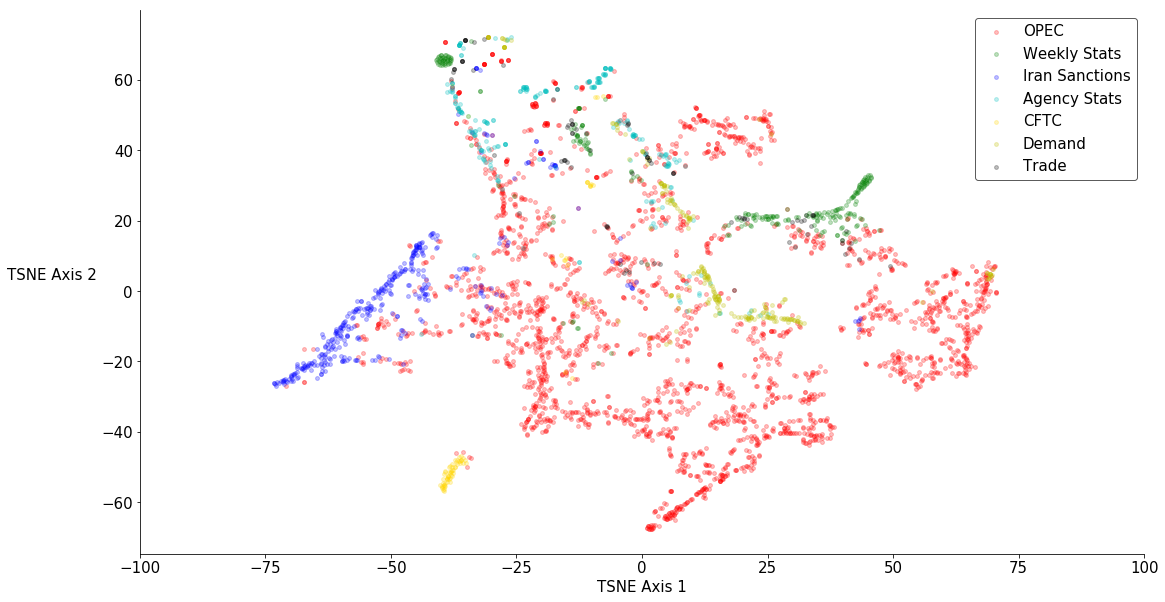

In [44]:
colorize = []

fig, ax = plt.subplots(figsize=(18, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, c, label in zip(target_ids, colors, target_names):
        ax = plt.scatter(tsne_data[target == i, 0], tsne_data[target == i, 1], c=c, label=label, s=15, alpha=.25)


plt.legend(fontsize=15, loc='best', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
#plt.title("Topic Clusters with tSNE", fontsize=20)
plt.ylabel("TSNE Axis 2", fontsize=15, rotation='horizontal', ha='right')
plt.xlabel("TSNE Axis 1", fontsize=15);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

#### Looking at the number of topics using scree plot

In [45]:
X = df_countvectorize

In [46]:
pca2 = TruncatedSVD(n_components=15)
pca2.fit(X)
pca_data2 = pca2.transform(X)

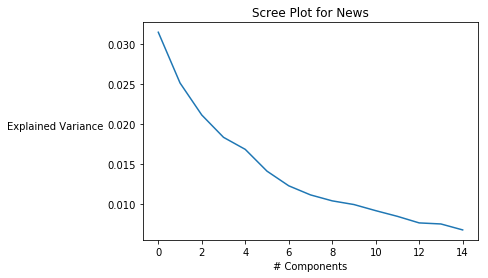

In [47]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# Components')
plt.ylabel('Explained Variance', rotation='horizontal', ha='right');
plt.title('Scree Plot for News');

#### LDA (Latent Dirichlet Allocation) Model in gensim

##### LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a ‘document vector’ will correspond with the number of times a word occurred in the document (Bag-of-Words BOW Representation).

In [48]:
# gensim
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import LatentDirichletAllocation as LDA

# sklearn
from sklearn import datasets

In [49]:
#convert to gensim
vectorizer.fit(df_news.News)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=5,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=frozenset({'seeming', 'describe', 'off', 'more', 'yourselves', 'next', 'formerly', 'or', 'therein', 'besides', 'ten', 'already', 'your', 'has', 'so', 'which', 'when', 'in', 'will', 'full', 'should', 'first', 'therefore', 'never', 'although', 'would', 'thus', 'seemed', 'wherever', 'uso', '...eyond', 'their', 'whereby', 'either', 'nor', 'thereby', 'two', 'throughout', 'hundred', 'anywhere'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [50]:
lda_doc = vectorizer.transform(df_news.News).transpose()

In [51]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(lda_doc)

In [52]:
#Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [53]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [54]:
# lda = LDA(n_components=7)
# lda.fit(count_data)

In [55]:
# Create lda model (equivalent to "fit" in sklearn)
ldamodel = models.LdaModel(corpus=corpus, num_topics=7, id2word=id2word)

In [56]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.020*"production" + 0.015*"output" + 0.008*"sanction" + 0.008*"estimate" + 0.007*"iran" + 0.007*"increase" + 0.007*"cut" + 0.006*"iranian" + 0.006*"year" + 0.005*"eia"'),
 (1,
  '0.011*"saudi" + 0.010*"russia" + 0.008*"barrel" + 0.008*"arabia" + 0.008*"saudi arabia" + 0.007*"production" + 0.007*"cut" + 0.006*"meet" + 0.006*"add" + 0.005*"global"'),
 (2,
  '0.014*"iran" + 0.012*"sanction" + 0.008*"add" + 0.008*"new" + 0.008*"trump" + 0.006*"production" + 0.006*"cut" + 0.006*"china" + 0.006*"price" + 0.006*"energy"'),
 (3,
  '0.008*"venezuela" + 0.007*"trump" + 0.006*"iran" + 0.006*"company" + 0.006*"sanction" + 0.005*"add" + 0.005*"export" + 0.005*"global" + 0.005*"saudi" + 0.005*"waivers"'),
 (4,
  '0.013*"saudi" + 0.013*"production" + 0.013*"supply" + 0.011*"demand" + 0.010*"price" + 0.009*"saudi arabia" + 0.009*"year" + 0.009*"arabia" + 0.008*"cut" + 0.007*"global"'),
 (5,
  '0.017*"production" + 0.010*"cut" + 0.008*"price" + 0.008*"output" + 0.007*"increase" + 0.007*"iran" 

In [57]:
#Save the model for future use
ldamodel.save('topic.model')

In [58]:
#Load it back up
# from gensim.models import LdaModel
# loading = LdaModel.load('topic.model')

In [59]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [60]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
# dictionary = corpora.Dictionary(text_list)
# dictionary.save('dictionary.dict')

In [61]:
# d = gensim.corpora.Dictionary.load('dictionary.dict')
# c = gensim.corpora.MmCorpus('corpus.mm')
# lda = gensim.models.LdaModel.load('topic.model')

#### Combine DF with dates and normalize the topic by weight

In [62]:
df_topics = topic_matrix_nmf.copy()

In [63]:
df_topics.head()

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade
News,,,,,,,
market,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,0.076545,0.036042,0.010246,0.076431,0.090534,0.024310,0.038454
traders reduce bullish stance on brent bloomberg report that traders reduce their bullish stance on brent for a second week as they brace for market swing relate to the high profile meet of opec members in vienna later this week it observe money managers cut their brent net long position by for the week end nov with a decline in short outpace a decline in long,0.021615,0.000000,0.008921,0.018638,0.498127,0.000000,0.000000
oil options the cheapest in three years bloomberg report that imply volatility of options on second month wti futures fell to on friday the lowest level since october add that volatility have be sink as futures have move steadily higher,0.021517,0.004419,0.007093,0.000000,0.065035,0.026361,0.063032
opec,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
df_topics['weighted_sum'] = df_topics.sum(axis=1)

In [65]:
df_topics.head(2)

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,weighted_sum
News,,,,,,,,
market,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,0.076545,0.036042,0.010246,0.076431,0.090534,0.02431,0.038454,0.352561


In [66]:
df_topics['OPEC'] = df_topics['OPEC']/df_topics['weighted_sum']

In [67]:
df_topics['Weekly_Stats'] = df_topics['Weekly_Stats']/df_topics['weighted_sum']

In [68]:
df_topics['Iran_Sanctions'] = df_topics['Iran_Sanctions']/df_topics['weighted_sum']

In [69]:
df_topics['Agency_Stats'] = df_topics['Agency_Stats']/df_topics['weighted_sum']

In [70]:
df_topics['CFTC'] = df_topics['CFTC']/df_topics['weighted_sum']

In [71]:
df_topics['Demand'] = df_topics['Demand']/df_topics['weighted_sum']

In [72]:
df_topics['Trade'] = df_topics['Trade']/df_topics['weighted_sum']

In [73]:
df_topics['date']= df_news.index

#### Drop the rows that don't have any topic

In [74]:
df_topics = df_topics.drop(df_topics[df_topics.weighted_sum == 0].index)

In [75]:
df_topics['date'] =  pd.to_datetime(df_topics['date'], format='%Y-%m-%d:%H:%M:%S')

In [76]:
type(df_topics.date[0])

pandas._libs.tslibs.timestamps.Timestamp

#### Find the average topic weight per day

In [77]:
df_topics['day'] = df_topics.date.dt.date

In [78]:
# Get number of news items per day
total_items = df_topics.groupby('day')['weighted_sum'].apply(lambda x: len(x.unique())).reset_index()
total_items.columns = ['day', 'total_items']

In [79]:
total_items.head()

,day,total_items
0,2017-11-27,14
1,2017-11-28,15
2,2017-11-29,15
3,2017-11-30,11
4,2017-12-01,6


In [80]:
#Find the aggregated sum per topic per day
df_avg = df_topics.groupby('day').agg("sum", axis="columns")

In [81]:
df_avg.head()

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,weighted_sum
day,,,,,,,,
2017-11-27,2.226905,0.190188,1.646246,1.449115,1.895500,1.056187,5.535860,4.248297
2017-11-28,3.271678,0.845918,0.114695,2.453148,0.567471,1.958865,5.788225,3.997664
2017-11-29,2.102658,1.636748,0.050468,1.142559,0.985178,1.845764,7.236625,4.624350
2017-11-30,2.847714,0.842955,1.010399,2.753950,0.270152,0.831262,2.443568,2.638375
2017-12-01,2.094000,0.364477,0.696585,0.239308,0.189971,0.362969,2.052691,1.884291


In [82]:
df_avg = df_avg.merge(total_items, on="day", how="left")

In [83]:
df_avg.head()

,day,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,weighted_sum,total_items
0,2017-11-27,2.226905,0.190188,1.646246,1.449115,1.895500,1.056187,5.535860,4.248297,14
1,2017-11-28,3.271678,0.845918,0.114695,2.453148,0.567471,1.958865,5.788225,3.997664,15
2,2017-11-29,2.102658,1.636748,0.050468,1.142559,0.985178,1.845764,7.236625,4.624350,15
3,2017-11-30,2.847714,0.842955,1.010399,2.753950,0.270152,0.831262,2.443568,2.638375,11
4,2017-12-01,2.094000,0.364477,0.696585,0.239308,0.189971,0.362969,2.052691,1.884291,6


In [84]:
# compute the mean per topic
df_topic_mean = df_avg[['OPEC','Weekly_Stats','Iran_Sanctions', 'Agency_Stats',\
        'CFTC', 'Demand', 'Trade']].div(df_avg['total_items'], axis=0)

In [85]:
sum(df_topic_mean.iloc[0])

0.9999999999999999

In [86]:
df_topic_mean['day'] = df_avg['day']

In [87]:
df_topic_mean.head()

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,day
0,0.159065,0.013585,0.117589,0.103508,0.135393,0.075442,0.395419,2017-11-27
1,0.218112,0.056395,0.007646,0.163543,0.037831,0.130591,0.385882,2017-11-28
2,0.140177,0.109117,0.003365,0.076171,0.065679,0.123051,0.482442,2017-11-29
3,0.258883,0.076632,0.091854,0.250359,0.024559,0.075569,0.222143,2017-11-30
4,0.349000,0.060746,0.116097,0.039885,0.031662,0.060495,0.342115,2017-12-01


In [88]:
df_topic_mean.index = df_topic_mean.day

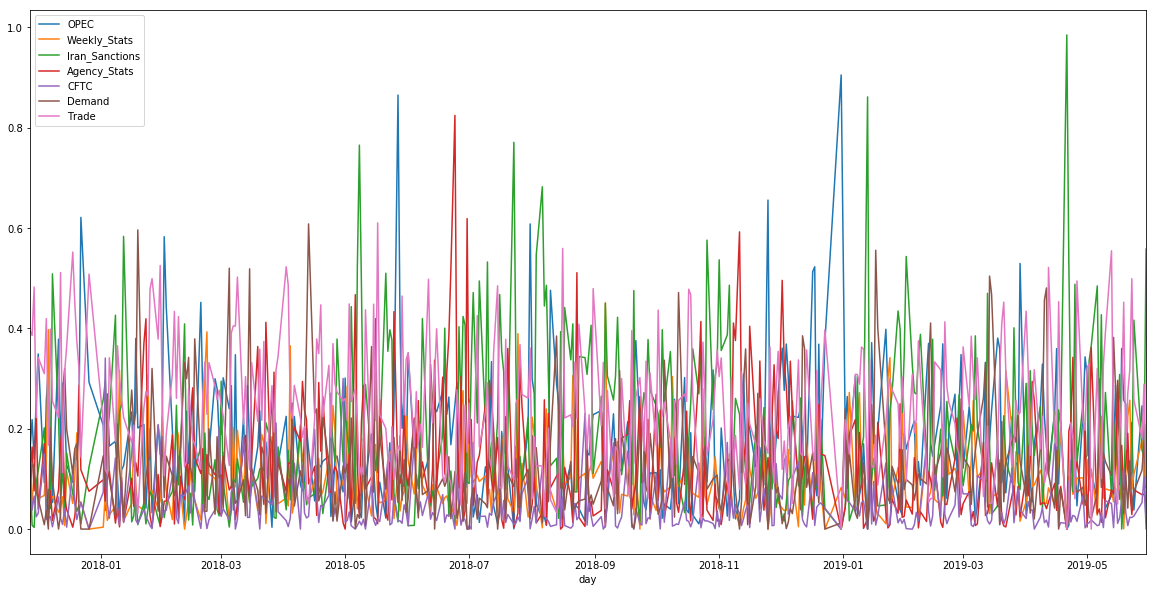

In [89]:
df_topic_mean.plot(x='day', figsize=(20,10))

#### Save to pickle for later use

In [90]:
df_topic_mean.to_pickle('ts_topic_mean.pkl')

## Sentiment Analysis

In [91]:
corpus = df_topics.index

In [125]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn(emoticons=True)

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(i) for i in corpus]
sentiment_category = [score/5 if score > 0 
                          else score/5 if score < 0 
                              else 0.01 
                                  for score in sentiment_scores]
    

# topic_matrix['topic_name'] = topic_matrix.topic_id.replace({0: 'Saudi Attack', 1: 'Energy Stats', 2:\
#                                                             'Trade War', 3: "Iran Sanctions"})

# # sentiment statistics per news category
# df_sentiment = pd.DataFrame([list(topic_matrix.topic_name), sentiment_scores, sentiment_category]).T
# df_sentiment.columns = ['Topic', 'sentiment_score', 'sentiment_category']
# df_sentiment['sentiment_score'] = df_sentiment.sentiment_score.astype('float')
# df_sentiment.groupby(by=['Topic']).describe()

In [126]:
df_topics['sentiment'] = sentiment_scores

In [127]:
df_topics['sentiment_category'] = sentiment_category

In [128]:
df_topics.head()

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,weighted_sum,date,day,sentiment,sentiment_category
News,,,,,,,,,,,,
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,0.217110,0.102228,0.029061,0.216789,0.256789,0.068952,0.109070,0.352561,2017-11-27 06:31:00,2017-11-27,3.0,0.6
traders reduce bullish stance on brent bloomberg report that traders reduce their bullish stance on brent for a second week as they brace for market swing relate to the high profile meet of opec members in vienna later this week it observe money managers cut their brent net long position by for the week end nov with a decline in short outpace a decline in long,0.039493,0.000000,0.016300,0.034054,0.910153,0.000000,0.000000,0.547301,2017-11-27 06:31:00,2017-11-27,-1.0,-0.2
oil options the cheapest in three years bloomberg report that imply volatility of options on second month wti futures fell to on friday the lowest level since october add that volatility have be sink as futures have move steadily higher,0.114781,0.023576,0.037839,0.000000,0.346934,0.140622,0.336248,0.187457,2017-11-27 06:31:00,2017-11-27,-1.0,-0.2
cartel beset by doubt that market may over tighten the wsj report that ahead of this week s meet of opec members in vienna the cartel be beset by doubt about whether continue production cut will help its members or if there be a risk that these could overstimulate the market and send price too high next year it note that should opec overshoot it could depress demand and even accelerate a push toward electric vehicles and other technologies expect to cut into oil consumption,0.353984,0.000000,0.000000,0.078834,0.045788,0.209757,0.311637,0.423353,2017-11-27 06:31:00,2017-11-27,-5.0,-1.0
russia be the most pivotal member of the output agreement the wsj note that while russia may be the most pivotal member of opec s production cut agreement it isn t even a cartel member it add that the country be a challenge partner in that it doesn t have a single large state own oil company to corral and that russian president putin be in a strong negotiate position and may be able to craft an agreement give his country some wiggle room,0.481125,0.000000,0.127342,0.149720,0.141149,0.000000,0.100663,0.398199,2017-11-27 06:31:00,2017-11-27,3.0,0.6


In [154]:
df_topics.to_csv('df_topics.csv')

#### Find the aggregated sum per topic per day accounting for sentiment

In [129]:
# compute the mean per topic
df_topic_sentiment = df_topics[['OPEC','Weekly_Stats','Iran_Sanctions', 'Agency_Stats',\
        'CFTC', 'Demand', 'Trade']].multiply(df_topics['sentiment_category'], axis=0)

In [130]:
df_topic_sentiment['day'] = df_topics['day']

In [131]:
df_topic_sentiment = df_topic_sentiment.merge(total_items, on="day", how="left")

In [132]:
df_topic_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3697 entries, 0 to 3696
Data columns (total 9 columns):
OPEC              3697 non-null float64
Weekly_Stats      3697 non-null float64
Iran_Sanctions    3697 non-null float64
Agency_Stats      3697 non-null float64
CFTC              3697 non-null float64
Demand            3697 non-null float64
Trade             3697 non-null float64
day               3697 non-null object
total_items       3697 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 288.8+ KB


In [133]:
df_topic_sentiment.index = df_topics.index

In [134]:
df_topic_sentiment.head()

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade,day,total_items
News,,,,,,,,,
wti january down to and brent january down to oil be lower after three days of gain with the market look ahead to thursday s opec meet while the consensus be that the meet will generate some type of extension for the cartel s ongoing output cut at the same time there be some concern about russia s level of commitment as well as rise concern about whether the move will overshoot their goals there be also some sense that after a long run higher crude could be poise for a selloff,0.130266,0.061337,0.017437,0.130073,0.154073,0.041371,0.065442,2017-11-27,14
traders reduce bullish stance on brent bloomberg report that traders reduce their bullish stance on brent for a second week as they brace for market swing relate to the high profile meet of opec members in vienna later this week it observe money managers cut their brent net long position by for the week end nov with a decline in short outpace a decline in long,-0.007899,-0.000000,-0.003260,-0.006811,-0.182031,-0.000000,-0.000000,2017-11-27,14
oil options the cheapest in three years bloomberg report that imply volatility of options on second month wti futures fell to on friday the lowest level since october add that volatility have be sink as futures have move steadily higher,-0.022956,-0.004715,-0.007568,-0.000000,-0.069387,-0.028124,-0.067250,2017-11-27,14
cartel beset by doubt that market may over tighten the wsj report that ahead of this week s meet of opec members in vienna the cartel be beset by doubt about whether continue production cut will help its members or if there be a risk that these could overstimulate the market and send price too high next year it note that should opec overshoot it could depress demand and even accelerate a push toward electric vehicles and other technologies expect to cut into oil consumption,-0.353984,-0.000000,-0.000000,-0.078834,-0.045788,-0.209757,-0.311637,2017-11-27,14
russia be the most pivotal member of the output agreement the wsj note that while russia may be the most pivotal member of opec s production cut agreement it isn t even a cartel member it add that the country be a challenge partner in that it doesn t have a single large state own oil company to corral and that russian president putin be in a strong negotiate position and may be able to craft an agreement give his country some wiggle room,0.288675,0.000000,0.076405,0.089832,0.084689,0.000000,0.060398,2017-11-27,14


In [150]:
#Find the aggregated sum per topic per day
# df_topic_avg = df_topic_sentiment.groupby('day').agg("sum", axis="columns")
df_topic_avg = df_topic_sentiment.groupby('day').mean()
df_topic_avg.drop(columns='total_items', inplace=True)

In [136]:
# compute the mean per topic
# df_topic_avg = df_topic_avg[['OPEC','Weekly_Stats','Iran_Sanctions', 'Agency_Stats',\
#         'CFTC', 'Demand', 'Trade']].div(df_topic_avg['total_items'], axis=0)

In [151]:
df_topic_avg.head(5)

,OPEC,Weekly_Stats,Iran_Sanctions,Agency_Stats,CFTC,Demand,Trade
day,,,,,,,
2017-11-27,0.004908,0.001807,-0.003041,-0.027139,-0.004035,-0.011038,-0.115747
2017-11-28,0.057140,0.000134,0.001153,0.033782,0.037230,0.156235,0.170325
2017-11-29,0.021902,-0.047027,0.000218,0.037296,0.001414,0.000415,0.015115
2017-11-30,0.042914,0.001006,0.017936,0.102312,0.005569,0.007411,0.007397
2017-12-01,0.329305,0.026028,0.016290,0.020985,0.016999,0.041326,0.115734


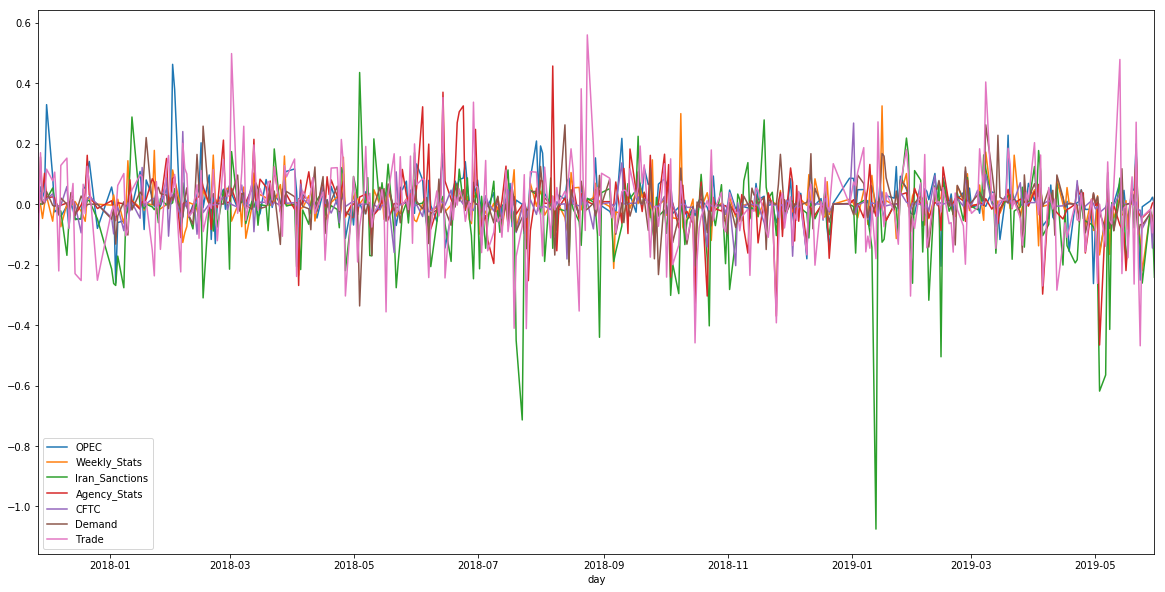

In [152]:
df_topic_avg.plot(figsize=(20,10))

#### Save to pickle to feed into time series analysis

In [155]:
df_topic_avg.to_pickle('ts_topic_sentiment.pkl')

In [139]:
df_topic_avg.to_csv('ts_topic_sentiment.csv')